### Test case LVV-T389 - Single Visit Photometric Repeatability

Verify that the RMS of magnitudes in all filters and outlier rate of magnitudes is within specification.

#### Discussion:

This test can be verified using data products produced during Data Release Processing campaigns executed by the Data Management pipelines team. In particular, we will use the LSST ComCam data as reprocessed with weekly pipelines version w_2025_04, in Butler collection “LSSTComCam/runs/DRP/DP1/w_2025_04/DM-48556".

The `PA1` and `PF1` metrics and related plots are created by tasks in the `analysis_tools` package. Thus verification of this requirement can be accomplished by simply retrieving the datasets produced by those tasks and confirming that they meet the required accuracy.

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.table import Table, hstack

from lsst.daf.butler import Butler
from IPython.display import Image

In [2]:
# Initialize the butler repo pointing to the DM-48556 (w_2025_04) collection
repo = '/repo/main'
collection = 'LSSTComCam/runs/DRP/DP1/w_2025_04/DM-48556'

butler = Butler(repo, collections=collection)

#### Retrieve the metrics from the butler

The photometric repeatability metrics are created by `analysis_tools`, and reside in datasets of type `matchedVisitCore_metrics`. Use a butler query to identify all of the existing LSSTComCam datasets of this type.

In [24]:
metrics_all = butler.query_datasets('matchedVisitCore_metrics', where="skymap='lsst_cells_v1'")

The query returns references to `matchedVisitCore_metrics` datasets, which are `MetricBundle`s. The following cell extracts each `MetricBundle` from the butler, then extracts the relevant metrics (`{band}_stellarPhotRepeatStdev` for PA1, and `{band}_stellarPhotRepeatOutlierFraction` for PF1) to a table.

In [179]:
tracts = []
bands = []
PA1_all = []
PF1_all = []

for met_ref in metrics_all:
    metrics = butler.get(met_ref)
    mets = metrics['stellarPhotometricRepeatability']
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        tracts.append(met_ref.dataId['tract'])
        bands.append(band)
        pa1_metric = band+'_stellarPhotRepeatStdev'
        pf1_metric = band+'_stellarPhotRepeatOutlierFraction'
        for m in mets:
            if m.metric_name.metric == pa1_metric:
                PA1_all.append(m.quantity.value)
            if m.metric_name.metric == pf1_metric:
                PF1_all.append(m.quantity.value)
                
tab_all = Table([tracts, bands, PA1_all, PF1_all], names=['tract', 'band', 'PA1', 'PF1'],
                units=[None, None, u.mmag, u.percent])

In [197]:
tab_all

tract,band,PA1,PF1
,,mmag,%
int64,str1,float64,float64
5305,u,4.079739968904113,0.0
5305,g,4.265091659286294,0.0
5305,r,nan,nan
5305,i,nan,nan
5305,z,2.987515517089404,0.0
5305,y,nan,nan
7611,u,6.2693341777326435,4.504504504504505
7611,g,10.480891391499414,5.288932419196866


The table includes metrics from all bands. Separately select the metrics corresponding to each band. Furthermore, because `PA1` and `PF1` are defined differently for "gri" and "uzy" bands, create selections for "gri" and "uzy" subsets.

In [122]:
sel_u = (tab_all['band']=='u')
sel_g = (tab_all['band']=='g')
sel_r = (tab_all['band']=='r')
sel_i = (tab_all['band']=='i')
sel_z = (tab_all['band']=='z')
sel_y = (tab_all['band']=='y')

sel_gri = sel_g | sel_r | sel_i
sel_uzy = sel_u | sel_z | sel_y


#### Distribution of metric values

`PA1` and `PF1` are measured _per tract_. Plot histograms of all tract measurements for these metrics, and compare their median values against the requirement thresholds.

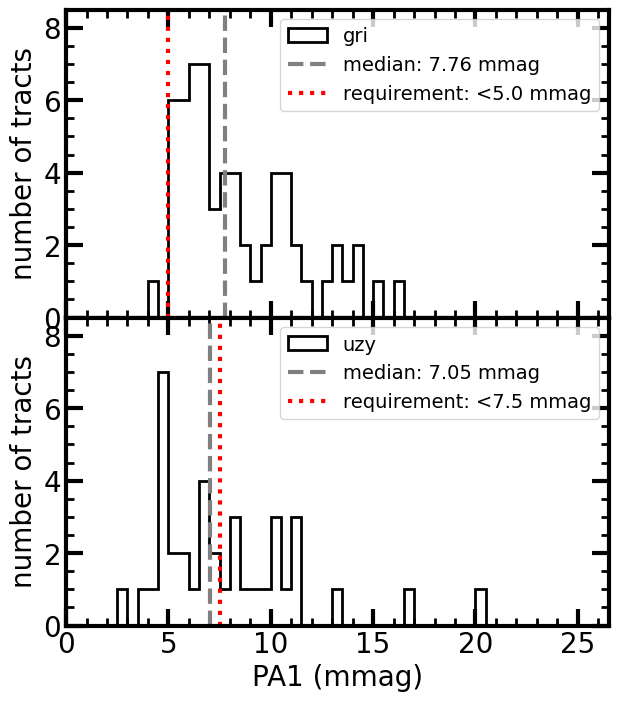

In [201]:
params = {'axes.labelsize': 20,
          'font.size': 20,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [7, 5],
          'figure.facecolor': 'White'}
plt.rcParams.update(params)

fig, ax = plt.subplots(2, 1, figsize=(7, 8), sharex=True)
plt.subplots_adjust(hspace=0)

plt.sca(ax[0])
plt.hist(tab_all[sel_gri]['PA1'], bins=np.arange(0, 25, 0.5), color='black', histtype='step', linewidth=2, label='gri')
pa1_gri_median = np.nanmedian(tab_all[sel_gri]['PA1'])
plt.vlines(pa1_gri_median, 0, 8.5, linestyle='--', color='Gray',
           label=f'median: {pa1_gri_median:.2f} mmag')
plt.vlines(5.0, 0, 8.5, linestyle=':', color='red',
           label='requirement: <5.0 mmag')
plt.xlim(0, 26.5)
plt.ylim(0, 8.5)
plt.legend()
plt.ylabel('number of tracts')
plt.minorticks_on()
plt.sca(ax[1])
plt.hist(tab_all[sel_uzy]['PA1'], bins=np.arange(0, 25, 0.5), color='black', histtype='step', linewidth=2, label='uzy')
pa1_uzy_median = np.nanmedian(tab_all[sel_uzy]['PA1'])
plt.vlines(pa1_uzy_median, 0, 8.5, linestyle='--', color='Gray',
           label=f'median: {pa1_uzy_median:.2f} mmag')
plt.vlines(7.5, 0, 8.5, linestyle=':', color='red',
           label='requirement: <7.5 mmag')
plt.xlim(0, 26.5)
plt.ylim(0, 8.5)
plt.legend()
plt.xlabel('PA1 (mmag)')
plt.ylabel('number of tracts')
plt.minorticks_on()
plt.show()

We see that the median value of `PA1_gri`=7.76 mmag exceeds the requirement threshold of 5.0 mmag. The median value of `PA1_uzy`=7.05 mmag meets the requirement.

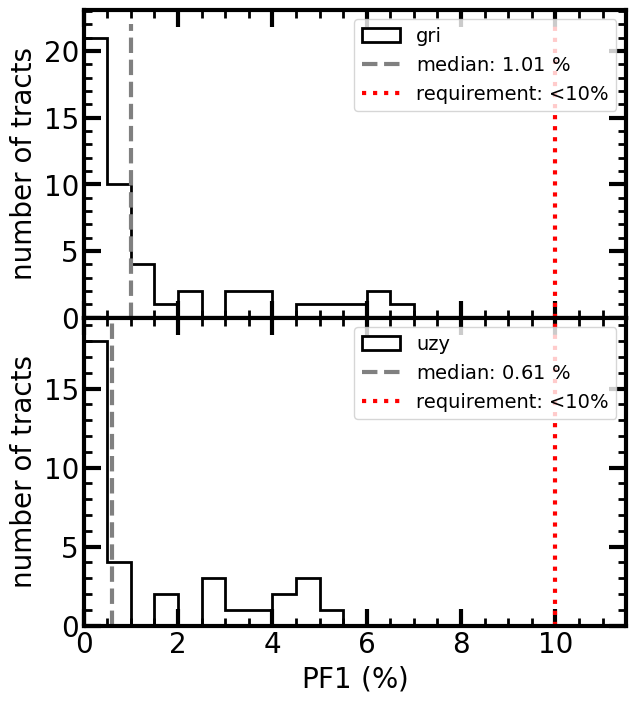

In [203]:
fig, ax = plt.subplots(2, 1, figsize=(7, 8), sharex=True)
plt.subplots_adjust(hspace=0)

plt.sca(ax[0])
plt.hist(tab_all[sel_gri]['PF1'], bins=np.arange(0, 7.5, 0.5), color='black', histtype='step', linewidth=2, label='gri')
pf1_gri_median = np.nanmedian(tab_all[sel_gri]['PF1'])
plt.vlines(pf1_gri_median, 0, 22, linestyle='--', color='Gray',
           label=f'median: {pf1_gri_median:.2f} $\%$')
plt.vlines(10.0, 0, 22, linestyle=':', color='red',
           label='requirement: <10%')
plt.xlim(0, 11.5)
# plt.ylim(0, 18.5)
plt.legend()
plt.ylabel('number of tracts')
plt.minorticks_on()
plt.sca(ax[1])
plt.hist(tab_all[sel_uzy]['PF1'], bins=np.arange(0, 7.5, 0.5), color='black', histtype='step', linewidth=2, label='uzy')
pf1_uzy_median = np.nanmedian(tab_all[sel_uzy]['PF1'])
plt.vlines(pf1_uzy_median, 0, 19.5, linestyle='--', color='Gray',
           label=f'median: {pf1_uzy_median:.2f} $\%$')
plt.vlines(10.0, 0, 22, linestyle=':', color='red',
           label='requirement: <10%')
plt.xlim(0, 11.5)
plt.ylim(0, 19.5)
plt.legend()
plt.xlabel(r'PF1 $(\%)$')
plt.ylabel('number of tracts')
plt.minorticks_on()
plt.show()

We see that the median values of both `PF1_gri` and `PF1_uzy` are well below the requirement threshold of 10%.

### Plots associated with the metrics

Retrieve the plots that are created alongside the metrics by `analysis_tools`, and display them in the notebook.

The following cell extracts a list of dataset references for all histograms of dataset type `matchedVisitCore_stellarPhotometricRepeatability_HistPlot`. These are per-tract, per-band histograms of the photometric repeatability over all visits.

In [225]:
plots_all = butler.query_datasets('matchedVisitCore_stellarPhotometricRepeatability_HistPlot',
                                  where="skymap='lsst_cells_v1'")

Display one of the plots. This is a histogram of the RMS repeatability values for all stars in a given tract/band.

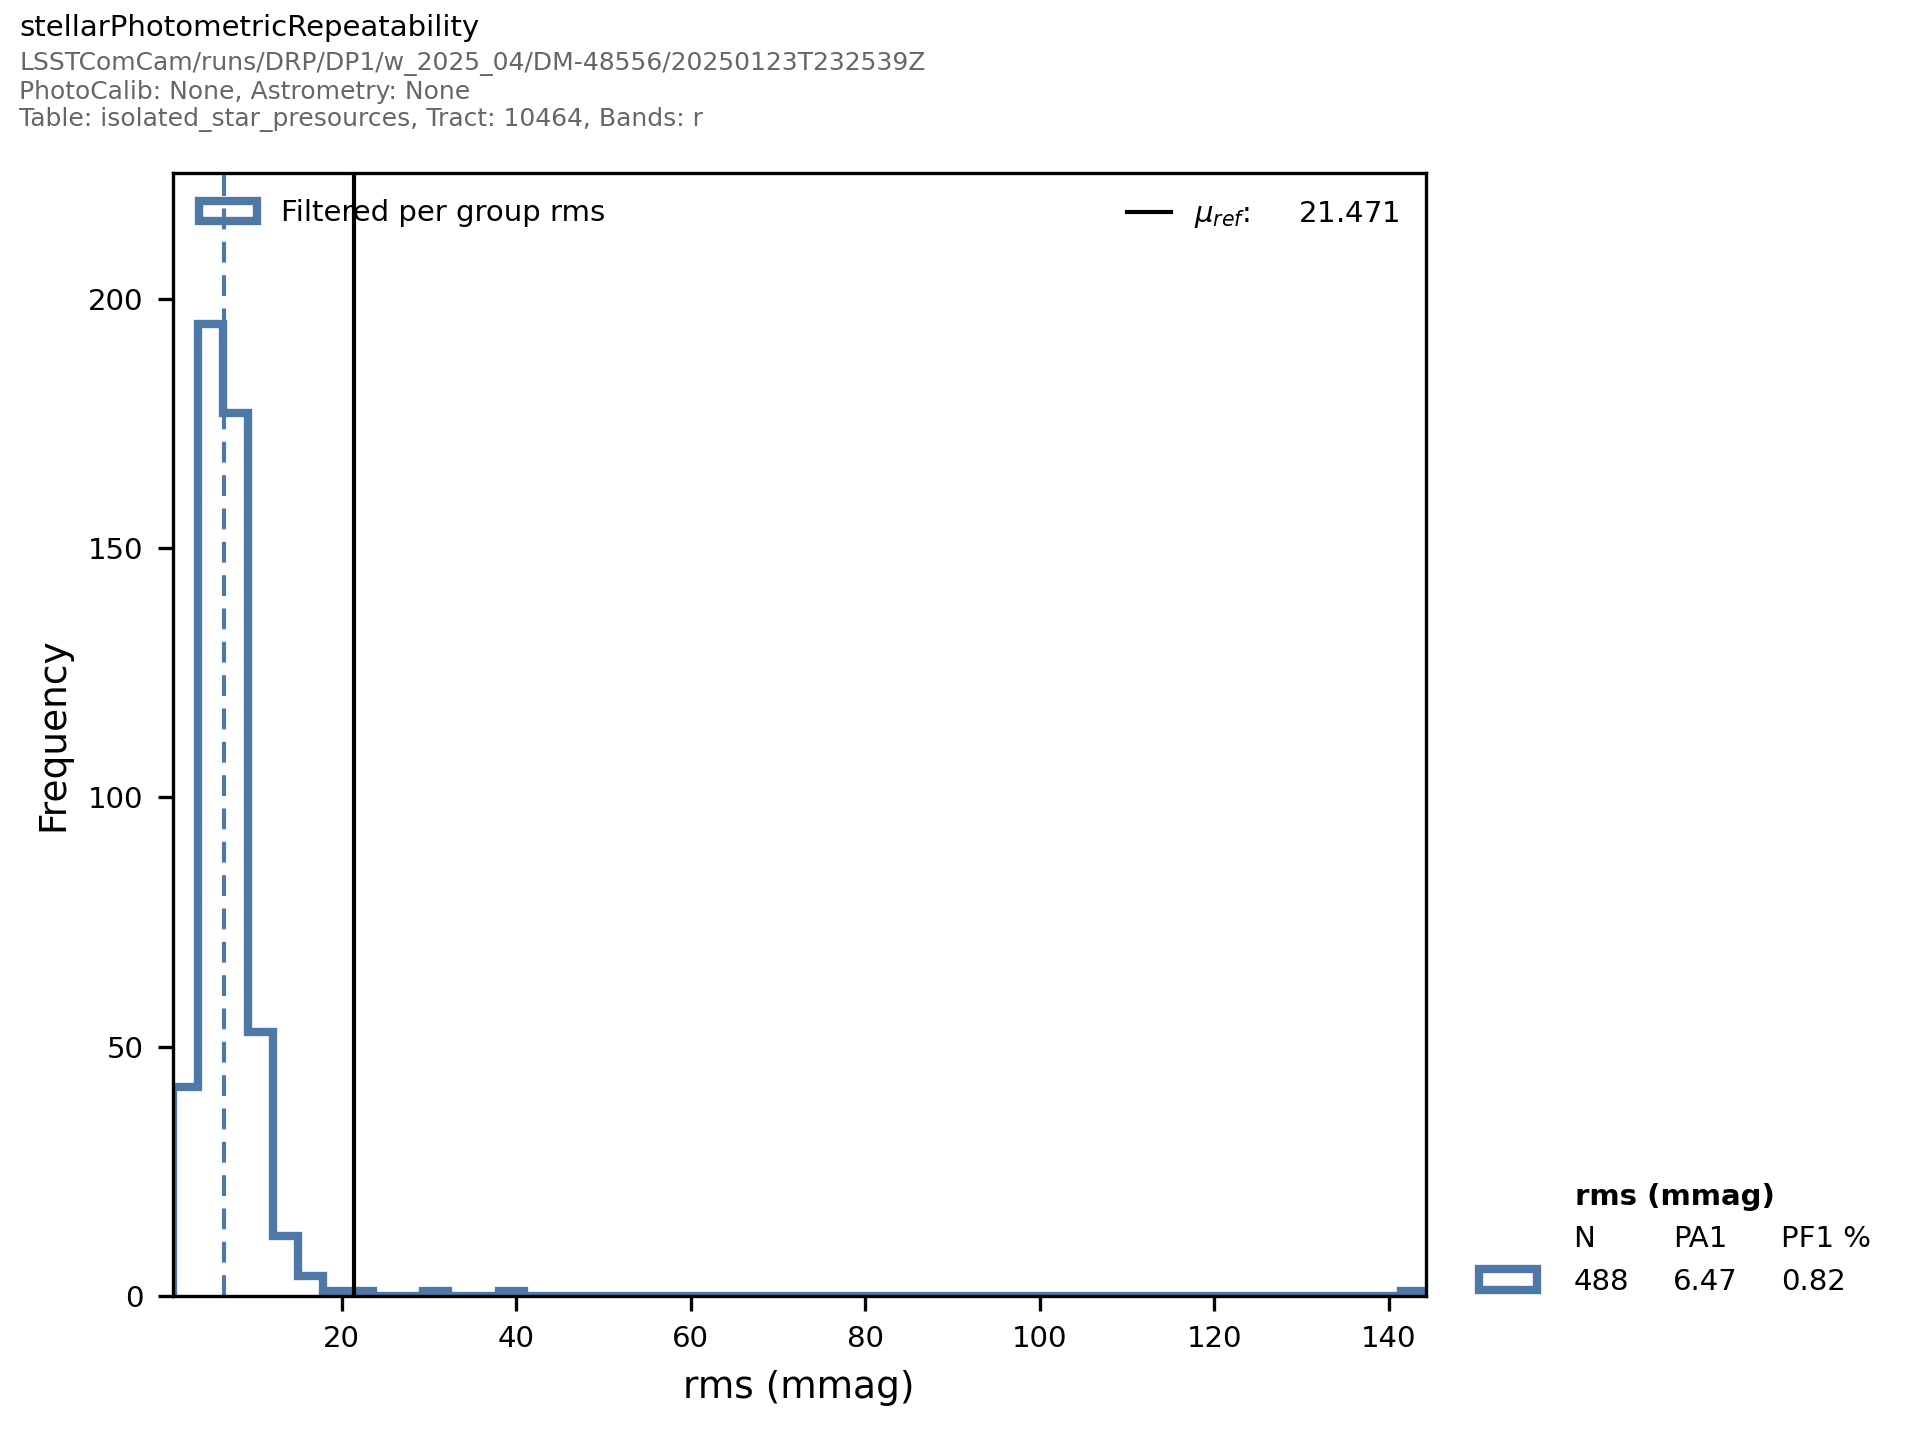

In [224]:
uri = butler.getURI(plots_all[12])
image_bytes = uri.read()
Image(image_bytes, width=600)


## Results
We have demonstrated that there is software within the Rubin Science Pipelines to calculate photometric repeatability (`PA1`) and the percentage of outliers (`PF1`). Additionally we have shown the metrics and plots that are produced by `analysis_tools` each time the DRP pipeline is executed.

The metrics measured on LSST ComCam data exceed the requirement threshold for `PA1_gri`, but meet the requirements for `PA1_uzy` and `PF1`. It is unclear whether `PA1_gri` reflects poor data quality (and/or effects of data processing), or whether it is more of a reflection of the limited datasets gathered during the ComCam on-sky campaign.

The result of this test is a "**Fail**", but could likely be passing with careful exploration of the outliers causing large repeatability in the "gri" bands.